In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

train_path = r"D:\USTH\Year_3\MachineLearning in Med\mlmed2025\Prac2\training_set"
image_files = sorted([f for f in os.listdir(train_path) if '_HC.png' in f and 'Annotation' not in f])

img_size = 128

images = []
masks = []

for img_file in image_files:
    img_path = os.path.join(train_path, img_file)
    mask_path = os.path.join(train_path, img_file.replace('.png', '_Annotation.png'))

    # Preprocess
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (img_size, img_size))
    mask = mask / 255.0  

    images.append(img)
    masks.append(mask)

X = np.array(images).reshape(-1, img_size, img_size, 1)
y = np.array(masks).reshape(-1, img_size, img_size, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (644, 128, 128, 1), Test shape: (162, 128, 128, 1)


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

def build_unet_with_batchnorm(input_shape):
    inputs = tf.keras.Input(input_shape)

    # Encoder Block 1
    c1 = layers.Conv2D(16, (3, 3), padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.ReLU()(c1)
    c1 = layers.Conv2D(16, (3, 3), padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.ReLU()(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    # Block 2
    c2 = layers.Conv2D(32, (3, 3), padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.ReLU()(c2)
    c2 = layers.Conv2D(32, (3, 3), padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.ReLU()(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = layers.Conv2D(64, (3, 3), padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.ReLU()(c3)
    c3 = layers.Conv2D(64, (3, 3), padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.ReLU()(c3)

    # Decoder Block 1
    u4 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = layers.Concatenate()([u4, c2])
    c4 = layers.Conv2D(32, (3, 3), padding='same')(u4)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.ReLU()(c4)
    c4 = layers.Conv2D(32, (3, 3), padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.ReLU()(c4)

    # Block 2
    u5 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.Concatenate()([u5, c1])
    c5 = layers.Conv2D(16, (3, 3), padding='same')(u5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.ReLU()(c5)
    c5 = layers.Conv2D(16, (3, 3), padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.ReLU()(c5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = models.Model(inputs, outputs)
    return model

unet_model = build_unet_with_batchnorm((img_size, img_size, 1))

unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
unet_model.summary()


early_stop = EarlyStopping(
    monitor='val_loss',    
    patience=5,            
    restore_best_weights=True 
)    
history = unet_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=20,
    callbacks=[early_stop] 
)



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ re_lu[0][0]       │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ re_lu_2[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ re_lu_3[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_4[0][0]  

 Total params: 118,033 (461.07 KB)

 Trainable params: 117,393 (458.57 KB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 538ms/step - accuracy: 0.5436 - loss: 0.7995 - val_accuracy: 0.9888 - val_loss: 0.5955
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 589ms/step - accuracy: 0.9815 - loss: 0.3420 - val_accuracy: 0.9888 - val_loss: 0.4772
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 599ms/step - accuracy: 0.9876 - loss: 0.2542 - val_accuracy: 0.9888 - val_loss: 0.3873
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 579ms/step - accuracy: 0.9886 - loss: 0.2025 - val_accuracy: 0.9888 - val_loss: 0.3161
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 644ms/step - accuracy: 0.9888 - loss: 0.1765 - val_accuracy: 0.9888 - val_loss: 0.2609
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 672ms/step - accuracy: 0.9887 - loss: 0.1462 - val_accuracy: 0.9888 - val_loss: 0.2054
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 691ms/step - accuracy: 0.9889 - loss: 0.1253 - val_accuracy: 0.9888 - val_loss: 0.1620
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 599ms/step - accuracy: 0.9887 - loss: 0.1095 - val_accu

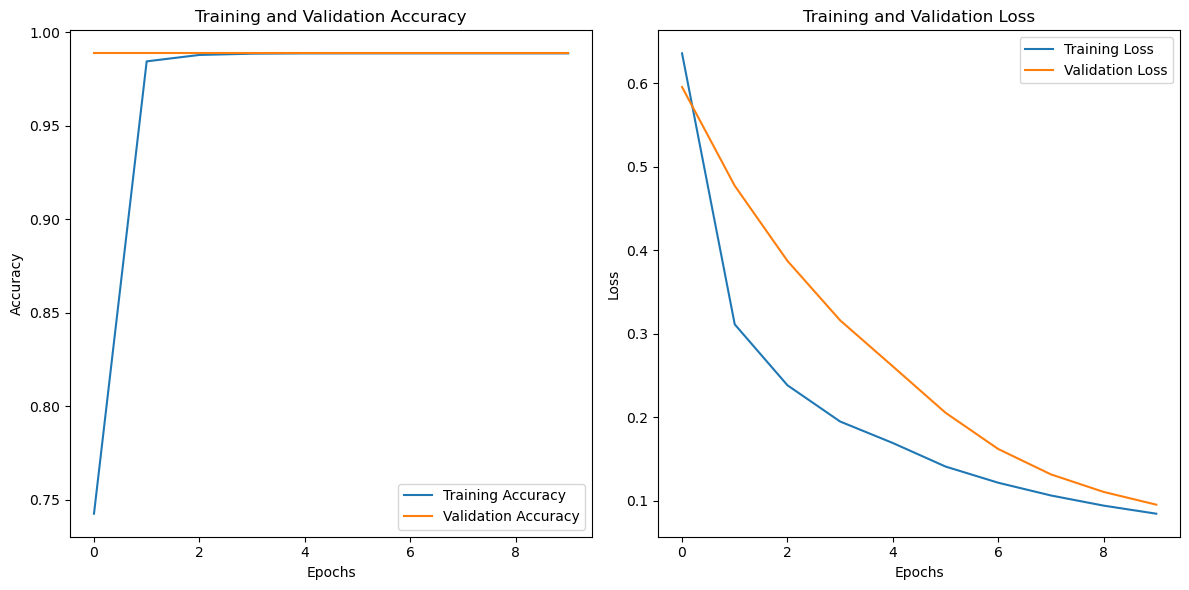

In [4]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()